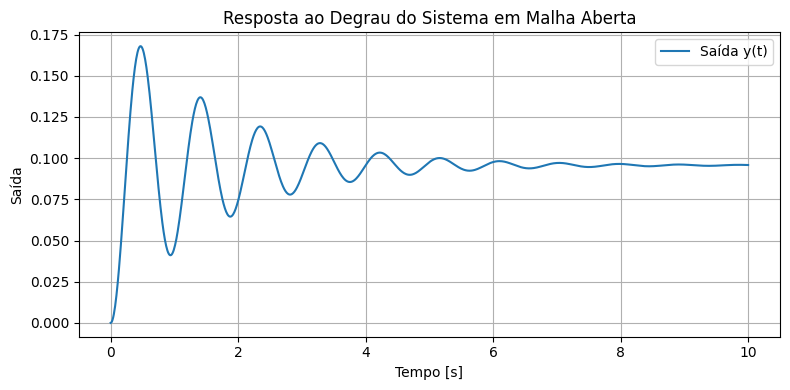

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Parâmetros do sistema
num = [4.326]   # Numerador
den = [1, 1.195, 45.207]  # Denominador

# Cria o sistema
system = signal.TransferFunction(num, den)

# Gera o tempo de simulação
t = np.linspace(0, 10, 1000)  # 0 a 10 segundos, 1000 pontos

# Simula a resposta ao degrau
t, y = signal.step(system, T=t)

# Plota resultado
plt.figure(figsize=(8, 4))
plt.plot(t, y, label='Saída y(t)')
plt.xlabel('Tempo [s]')
plt.ylabel('Saída')
plt.title('Resposta ao Degrau do Sistema em Malha Aberta')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

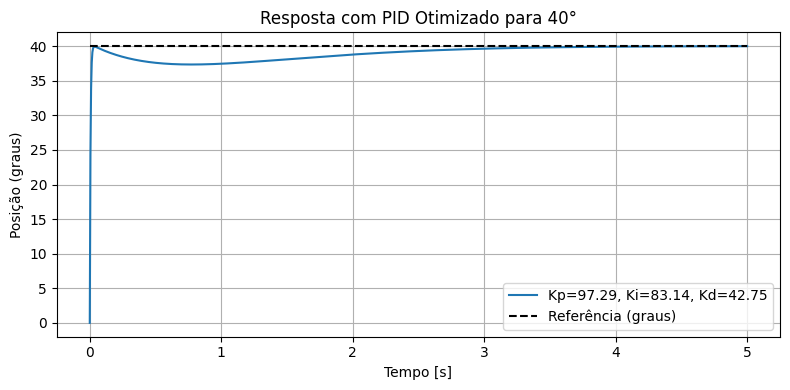

Ganhos PID ótimos: Kp=97.29, Ki=83.14, Kd=42.75


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, optimize

# Função de transferência da planta
num_plant = [4.326]
den_plant = [1, 1.195, 45.207]

# === Defina a posição desejada em graus ===
ref_graus = 40          # Por exemplo: 30 graus
ref = np.deg2rad(ref_graus)  # Converte para radianos

# Tempo de simulação
t = np.linspace(0, 5, 1000)

def simulate_pid_response(K, plot=False):
    Kp, Ki, Kd = K
    num_pid = [Kd, Kp, Ki]
    den_pid = [1, 0]
    num_ol = np.polymul(num_pid, num_plant)
    den_ol = np.polymul(den_pid, den_plant)
    system_closed = signal.TransferFunction(num_ol, np.polyadd(den_ol, num_ol))
    tout, yout = signal.step(system_closed, T=t)
    yout = yout * ref  # Escala a resposta para a referência desejada em radianos
    if plot:
        plt.plot(tout, np.rad2deg(yout), label=f"Kp={Kp:.2f}, Ki={Ki:.2f}, Kd={Kd:.2f}")
    return yout

def objective(K):
    yout = simulate_pid_response(K)
    return np.mean((yout - ref)**2)

initial_guess = [10, 5, 1]
bounds = [(0, 500), (0, 500), (0, 100)]

result = optimize.minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
best_K = result.x

plt.figure(figsize=(8, 4))
simulate_pid_response(best_K, plot=True)
plt.plot(t, np.ones_like(t)*ref_graus, 'k--', label='Referência (graus)')
plt.xlabel('Tempo [s]')
plt.ylabel('Posição (graus)')
plt.title(f'Resposta com PID Otimizado para {ref_graus}°')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Ganhos PID ótimos: Kp={best_K[0]:.2f}, Ki={best_K[1]:.2f}, Kd={best_K[2]:.2f}")

Ganhos ótimos: 200.0 200.0 50.0


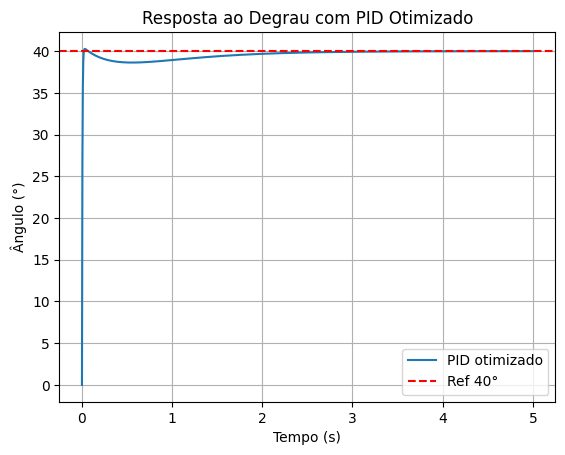

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import control

# Planta
num_p = [4.326]
den_p = [1, 1.195, 45.207]
G = control.TransferFunction(num_p, den_p)  # Usando control.TransferFunction

# referência (graus → rad)
ref_deg = 40
ref_rad = np.deg2rad(ref_deg)

t = np.linspace(0, 5, 1000)

def objective(K):
    Kp, Ki, Kd = K
    # controlador PID C(s) = Kd·s^2 + Kp·s + Ki / s
    C = control.TransferFunction([Kd, Kp, Ki], [1, 0])

    T_cl = control.feedback(C*G, 1)
    # resposta ao degrau de amplitude ref_rad
    t_sim, y = control.step_response(T_cl * ref_rad, T=t)  # Usando control.step_response
    # converte saída pra graus e calcula MSE
    y_deg = np.rad2deg(y)
    err = y_deg - ref_deg
    return np.mean(err**2)

# busca global de ganhos
bounds = [(0,200), (0,200), (0,50)]
res = optimize.differential_evolution(objective, bounds, maxiter=50)

Kp_opt, Ki_opt, Kd_opt = res.x
print("Ganhos ótimos:", Kp_opt, Ki_opt, Kd_opt)

# Plota a melhor resposta
C_opt = control.TransferFunction([Kd_opt, Kp_opt, Ki_opt], [1, 0])  # Usando control.TransferFunction
T_opt = control.feedback(C_opt*G, 1)
t2, y2 = control.step_response(T_opt * ref_rad, T=t)  # Usando control.step_response
y2_deg = np.rad2deg(y2)

plt.figure()
plt.plot(t2, y2_deg, label="PID otimizado")
plt.axhline(ref_deg, color='r', linestyle='--', label=f"Ref {ref_deg}°")
plt.xlabel("Tempo (s)")
plt.ylabel("Ângulo (°)")
plt.title("Resposta ao Degrau com PID Otimizado")
plt.grid(True)
plt.legend()
plt.show()

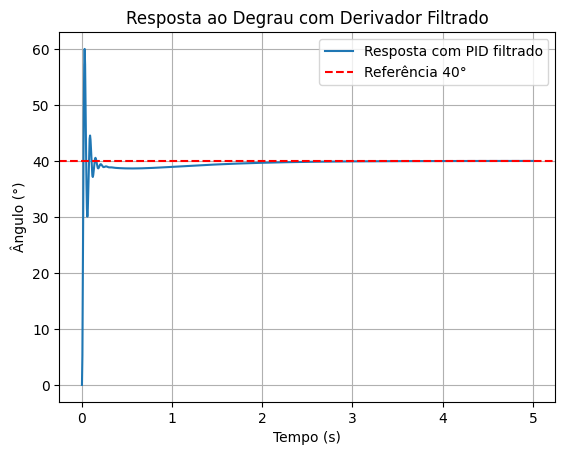

In [13]:
# ganhos já calculados (por Z-N, otimização, etc.)
Kp, Ki, Kd = Kp_opt, Ki_opt, Kd_opt

# parâmetro de filtragem (tune entre 10 e 100)
N = 50

# PID com derivador filtrado: C(s) = Kp + Ki/s + Kd*(N s)/(s+N)
# Usar control em vez de scipy.signal para as operações de transferência
from control import TransferFunction, feedback, step_response

Cp = TransferFunction([Kp], [1])
Ci = TransferFunction([Ki], [1, 0])
Cd = TransferFunction([Kd*N, 0], [1, N])
C = Cp + Ci + Cd  # Agora funciona com o control.TransferFunction

G = TransferFunction([4.326], [1, 1.195, 45.207])
T_cl = feedback(C * G, 1)
t = np.linspace(0, 5, 1000)
_, y = step_response(T_cl * np.deg2rad(40), T=t)
y_deg = np.rad2deg(y)

plt.figure()
plt.plot(t, y_deg, label="Resposta com PID filtrado")
plt.axhline(40, color='r', linestyle='--', label="Referência 40°")
plt.xlabel("Tempo (s)")
plt.ylabel("Ângulo (°)")
plt.title("Resposta ao Degrau com Derivador Filtrado")
plt.grid(True)
plt.legend()
plt.show()



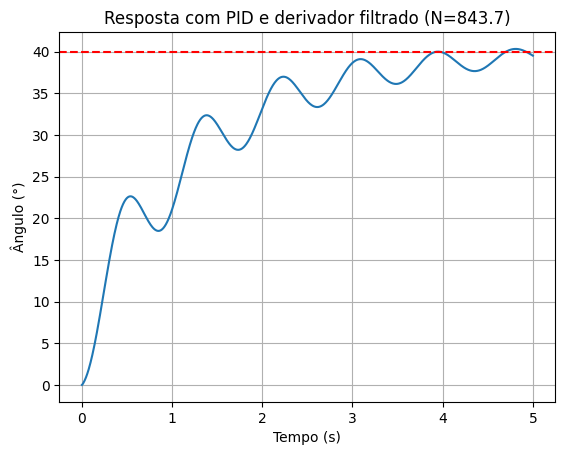

In [16]:
from control import TransferFunction, feedback, step_response
import numpy as np
import matplotlib.pyplot as plt

# ganhos (exemplo PID da tabela):
Kp, Ki, Kd = 1.9, 9.694, 0.0788
N = 843.7

# monta cada bloco
Cp = TransferFunction([Kp], [1])
Ci = TransferFunction([Ki], [1, 0])
Cd = TransferFunction([Kd * N, 0], [1, N])

C = Cp + Ci + Cd

# planta
G = TransferFunction([4.326], [1, 1.195, 45.207])

# malha fechada
T_cl = feedback(C * G, 1)

# simulação
t = np.linspace(0, 5, 1000)
_, y = step_response(T_cl * np.deg2rad(40), T=t)
y_deg = np.rad2deg(y)

plt.plot(t, y_deg)
plt.axhline(40, linestyle='--', color='r')
plt.xlabel('Tempo (s)')
plt.ylabel('Ângulo (°)')
plt.title('Resposta com PID e derivador filtrado (N=843.7)')
plt.grid(True)
plt.show()


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# === 1) Definições da planta ===
num_p = [4.326]
den_p = [1, 1.195, 45.207]
G = ctrl.TransferFunction(num_p, den_p)

# === 2) Encontrar Ku e Pu via Ziegler–Nichols (P-only) ===
def find_Ku_Pu(G):
    t = np.linspace(0, 50, 5000)
    for Ku in np.linspace(10, 1000, 500):  # Aumentando range e densidade da busca
        L = ctrl.feedback(Ku * G, 1)
        _, y = ctrl.step_response(L, T=t)
        y_cut = y[int(len(y)*0.5):]               # ignora os primeiros 50%
        # picos locais (oscilação sustentada)
        peaks = (np.diff(np.sign(np.diff(y_cut))) < 0).nonzero()[0]
        if len(peaks) >= 5:
            times = t[int(len(t)*0.5):][peaks]
            Pu = np.mean(np.diff(times))
            return Ku, Pu
    
    # Se falhar, usar um método alternativo baseado na análise de frequência
    import scipy.signal as sig
    w_range = np.logspace(-1, 4, 1000)
    mag, phase, _ = ctrl.freqresp(G, w_range)
    mag = mag.flatten()
    phase = phase.flatten()
    
    # Encontrar a frequência onde a fase é -180 graus (π radianos)
    phase_margin_idx = np.argmin(np.abs(phase + np.pi))
    w_180 = w_range[phase_margin_idx]
    
    # Ku é o inverso do ganho nessa frequência
# === 4) Estimar ωc (crossover) por análise de Bode de Lp = Kp·G ===
Lp = Kp * G
w = np.logspace(-1, 3, 2000)  # de 0.1 a 1000 rad/s
mag, phase, omega = ctrl.freqresp(Lp, w)
mag = mag.flatten()
# encontra último ponto onde mag>=1
idx = np.where(mag >= 1)[0]
if len(idx) == 0:
    # Se não houver crossover, calcular diretamente
    print("Aviso: Laço proporcional não cruza ganho unitário, estimando ωc...")
    # Usar a frequência de -180° como aproximação
    phase = phase.flatten()
    phase_margin_idx = np.argmin(np.abs(phase + np.pi))
    wc = omega[phase_margin_idx]
else:
    i = idx[-1]
    if i == len(mag)-1:
        # Se último ponto ainda estiver acima de 1, extrapolar
        wc = omega[-1]  # usar a última frequência disponível
    else:
        # interpola para refinar ωc
        w1, w2 = omega[i], omega[i+1]
        m1, m2 = mag[i], mag[i+1]
        wc = w1 + (1 - m1)*(w2 - w1)/(m2 - m1)
print(f"Crossover ωc ≈ {wc:.2f} rad/s")
Lp = Kp * G
w = np.logspace(-1, 3, 2000)  # de 0.1 a 1000 rad/s
mag, phase, omega = ctrl.freqresp(Lp, w)
mag = mag.flatten()
# encontra último ponto onde mag>=1
idx = np.where(mag >= 1)[0]
if len(idx) == 0:
    raise RuntimeError("Laço proporcional nunca ultrapassa ganho unitário")
i = idx[-1]
if i == len(mag)-1:
    raise RuntimeError("Último ponto do grid ainda acima de 1")
# interpola para refinar ωc
w1, w2 = omega[i], omega[i+1]
m1, m2 = mag[i], mag[i+1]
wc = w1 + (1 - m1)*(w2 - w1)/(m2 - m1)
print(f"Crossover ωc ≈ {wc:.2f} rad/s")

# === 5) Definir filtro derivativo N ===
alpha = 10.0
N = alpha * wc
print(f"Filtro derivativo N = {N:.1f} rad/s")

# === 6) Montar PID com derivador filtrado ===
Cp = ctrl.TransferFunction([Kp],     [1])
Ci = ctrl.TransferFunction([Ki],     [1, 0])
Cd = ctrl.TransferFunction([Kd * N, 0], [1, N])
C  = Cp + Ci + Cd

# === 7) Malha fechada e simulação ao degrau de 40° ===
T_cl = ctrl.feedback(C * G, 1)
t = np.linspace(0, 5, 1000)
ref_deg = 40
ref_rad = np.deg2rad(ref_deg)

t, y = ctrl.step_response(T_cl * ref_rad, T=t)
y_deg = np.rad2deg(y)

# === 8) Plots ===
plt.figure(figsize=(6,4))
plt.plot(t, y_deg, label="Resposta PID auto‑tunado")
plt.axhline(ref_deg, color='r', linestyle='--', label=f"Ref {ref_deg}°")
plt.xlabel("Tempo (s)")
plt.ylabel("Ângulo (°)")
plt.title("Resposta ao Degrau de 40° com PID+Filtro")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Aviso: Laço proporcional não cruza ganho unitário, estimando ωc...
Crossover ωc ≈ 1000.00 rad/s


RuntimeError: Laço proporcional nunca ultrapassa ganho unitário

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# === 1) Definições da planta ===
G = ctrl.TransferFunction([4.326], [1, 1.195, 45.207])

# === 2) Encontrar Ku e Pu via Ziegler–Nichols (P-only) ===
def find_Ku_Pu(G):
    t = np.linspace(0, 50, 5000)
    for Ku in np.linspace(1, 200, 200):
        CL = ctrl.feedback(Ku * G, 1)
        _, y = ctrl.step_response(CL, T=t)
        y_cut = y[len(y)//2:]               # ignora a primeira metade
        # detecção de mínimos locais (picos invertidos)
        peaks = (np.diff(np.sign(np.diff(y_cut))) < 0).nonzero()[0]
        if len(peaks) >= 5:
            times = t[len(t)//2:][peaks]
            Pu = np.mean(np.diff(times))
            return Ku, Pu
    raise RuntimeError("Não encontrou oscilações sustentadas")

Ku, Pu = find_Ku_Pu(G)
print(f"Ku = {Ku:.2f}, Pu = {Pu:.2f} s")

# === 3) Sintonia Ziegler–Nichols (PID clássico) ===
Kp = 0.6 * Ku
Ti = 0.5 * Pu
Td = 0.125 * Pu
Ki = Kp / Ti
Kd = Kp * Td
print(f"PID ZN → Kp={Kp:.2f}, Ki={Ki:.2f}, Kd={Kd:.2f}")

# === 4) Estimar ωc (crossover 0 dB) por freqresp de Lp = Kp·G ===
Lp = Kp * G
w = np.logspace(-2, 3, 5000)       # de 0.01 a 1000 rad/s
# freqresp retorna (H, ω); H é resposta complexa em cada ω
H, phase, w_out = ctrl.frequency_response(Lp, w)
mag = np.abs(H).flatten()

# encontra a faixa onde mag cruza 1
above = mag >= 1
if not np.any(above):
    raise RuntimeError("Laço proporcional nunca ultrapassa ganho unitário")
i = np.where(above)[0][-1]
if i == len(mag) - 1:
    raise RuntimeError("Último ponto do grid ainda acima de 1")
# interpola para refinar ωc
w1, w2 = w_out[i], w_out[i+1]
m1, m2 = mag[i], mag[i+1]
wc = w1 + (1 - m1)*(w2 - w1)/(m2 - m1)
print(f"Crossover ωc ≈ {wc:.2f} rad/s")

# === 5) Definir filtro derivativo N ===
alpha = 10.0
N = alpha * wc
print(f"Filtro derivativo N = {N:.1f} rad/s")

# === 6) Montar PID com derivador filtrado ===
Cp = ctrl.TransferFunction([Kp],       [1])
Ci = ctrl.TransferFunction([Ki],       [1, 0])
Cd = ctrl.TransferFunction([Kd * N, 0],[1, N])
C  = Cp + Ci + Cd

# === 7) Malha fechada e simulação ao degrau de 40° ===
T_cl = ctrl.feedback(C * G, 1)
t = np.linspace(0, 5, 1000)
ref_deg = 40
ref_rad = np.deg2rad(ref_deg)

# Get response, handling various control library versions properly
result = ctrl.step_response(T_cl * ref_rad, T=t)
# Handle different return formats from different control versions
if isinstance(result, tuple):
    if len(result) == 2:
        t_out, y = result
    else:
        t_out = result[0]
        y = result[1]
else:
    t_out = t
    y = result
y_deg = np.rad2deg(y)

# === 8) Plot final ===
plt.figure(figsize=(7,4))
plt.plot(t, y_deg, label="Resposta com PID auto‑tunado")
plt.axhline(ref_deg, color='r', linestyle='--', label=f"Ref {ref_deg}°")
plt.xlabel("Tempo (s)")
plt.ylabel("Ângulo (°)")
plt.title("Resposta ao Degrau de 40° com PID+Filtro Dinâmico")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Ku = 1.00, Pu = 0.90 s
PID ZN → Kp=0.60, Ki=1.34, Kd=0.07


RuntimeError: Laço proporcional nunca ultrapassa ganho unitário

Ku = 1.00, Pu = 0.67 s
PID ZN → Kp=0.60, Ki=1.78, Kd=0.05
ωn ≈ 6.72 rad/s, N = 67.2 rad/s


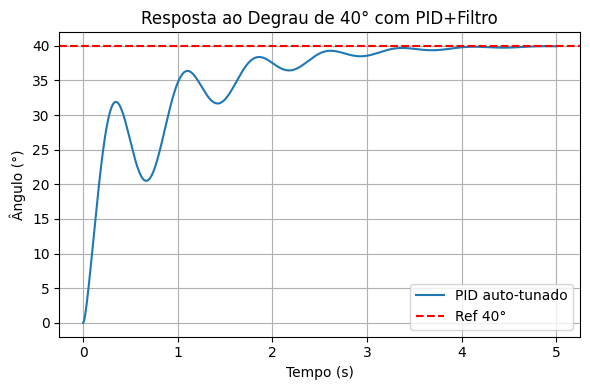

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# === 1) Definições da planta ===
m, L, g = 0.135, 0.217, 9.81
num_p = [g * 0.0275 / (m * L**2)]  # gamma/J já embutido
den_p = [1, 0.0076/(m*L**2), g/L]
G = ctrl.TransferFunction(num_p, den_p)

# === 2) Encontrar Ku e Pu (Z-N P-only) ===
def find_Ku_Pu(G):
    t = np.linspace(0, 50, 5000)
    for Ku in np.linspace(1, 200, 200):
        L_cl = ctrl.feedback(Ku * G, 1)
        _, y = ctrl.step_response(L_cl, T=t)
        y_cut = y[int(len(y)*0.5):]
        peaks = (np.diff(np.sign(np.diff(y_cut))) < 0).nonzero()[0]
        if len(peaks) >= 5:
            times = t[int(len(t)*0.5):][peaks]
            Pu = np.mean(np.diff(times))
            return Ku, Pu
    raise RuntimeError("Não encontrou oscilações sustentadas")

Ku, Pu = find_Ku_Pu(G)
print(f"Ku = {Ku:.2f}, Pu = {Pu:.2f} s")

# === 3) Sintonia Ziegler–Nichols (clássico PID) ===
Kp = 0.6 * Ku
Ti = 0.5 * Pu
Td = 0.125 * Pu
Ki = Kp / Ti
Kd = Kp * Td
print(f"PID ZN → Kp={Kp:.2f}, Ki={Ki:.2f}, Kd={Kd:.2f}")

# === 4) Definir N via frequência natural ωn ===
omega_n = np.sqrt(g / L)
alpha = 10.0
N = alpha * omega_n
print(f"ωn ≈ {omega_n:.2f} rad/s, N = {N:.1f} rad/s")

# === 5) Montar PID com derivador filtrado ===
Cp = ctrl.TransferFunction([Kp], [1])
Ci = ctrl.TransferFunction([Ki], [1, 0])
Cd = ctrl.TransferFunction([Kd * N, 0], [1, N])
C  = Cp + Ci + Cd

# === 6) Malha fechada e simulação ao degrau de 40° ===
T_cl = ctrl.feedback(C * G, 1)
t = np.linspace(0, 5, 1000)
ref_deg = 40
ref_rad = np.deg2rad(ref_deg)

t, y = ctrl.step_response(T_cl * ref_rad, T=t)
y_deg = np.rad2deg(y)

# === 7) Plot ===
plt.figure(figsize=(6,4))
plt.plot(t, y_deg, label="PID auto‑tunado")
plt.axhline(ref_deg, color='r', linestyle='--', label=f"Ref {ref_deg}°")
plt.xlabel("Tempo (s)")
plt.ylabel("Ângulo (°)")
plt.title("Resposta ao Degrau de 40° com PID+Filtro")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\saulo\AppData\Local\Temp\ipykernel_27932\151617974.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


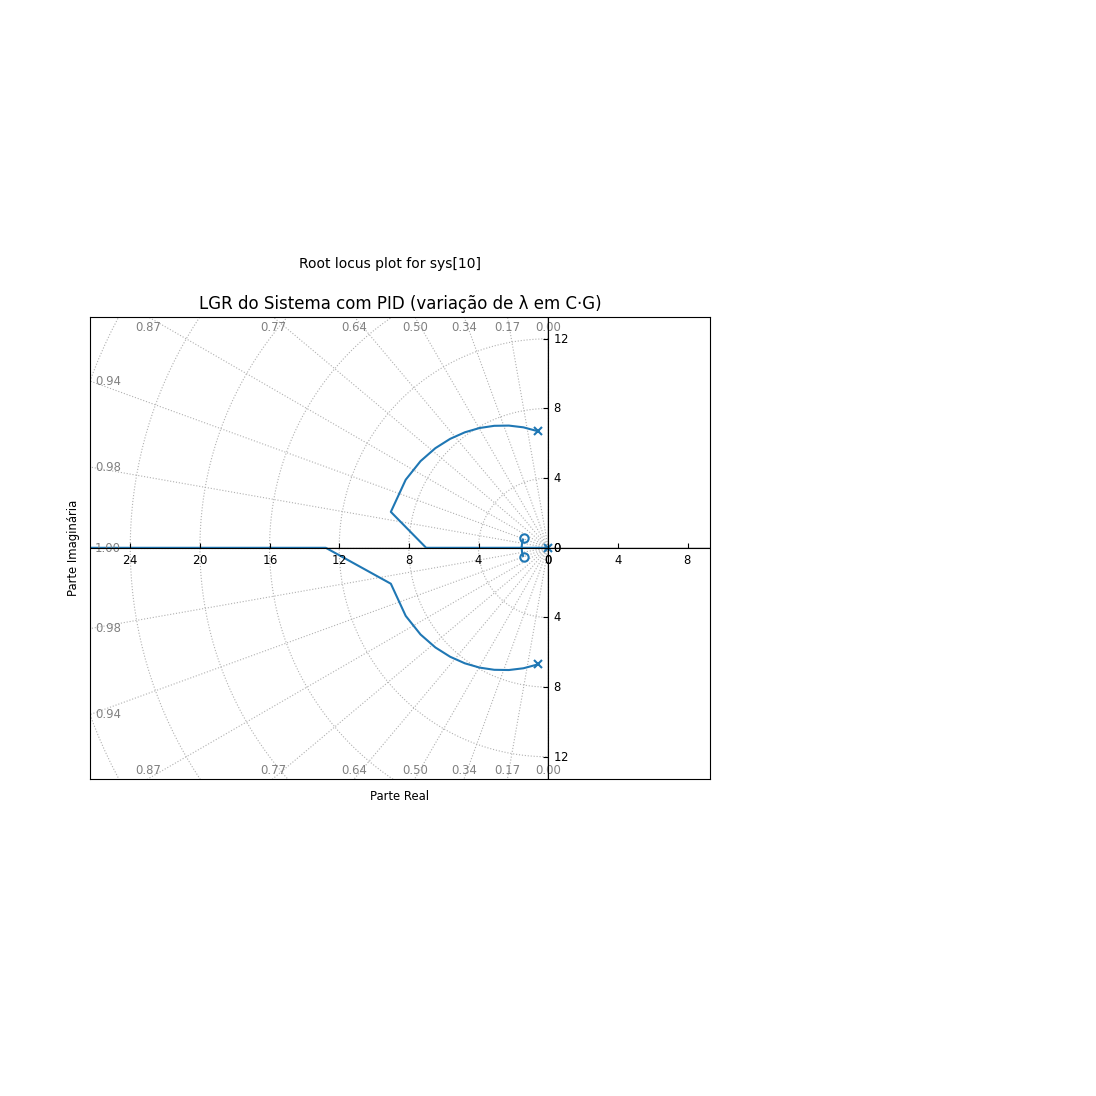

In [27]:
# Após a última célula de PID otimizado
import control
import matplotlib.pyplot as plt
import numpy as np

# Recupera os ganhos encontrados
Kp, Ki, Kd = best_K

# G(s) da planta
num_plant = [4.326]
den_plant = [1, 1.195, 45.207]
G = control.TransferFunction(num_plant, den_plant)

# C(s) do PID
# C(s) = (Kd s^2 + Kp s + Ki) / s
C = control.TransferFunction([Kd, Kp, Ki], [1, 0])

# Laço aberto com PID
L = C * G

# vetor de escalação do PID (lambda)
λ = np.linspace(0, 2, 500)  

plt.figure(figsize=(8,6))
control.root_locus(L, kvect=λ, grid=True)
plt.title("LGR do Sistema com PID (variação de λ em C·G)")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginária")
plt.tight_layout()
plt.show()

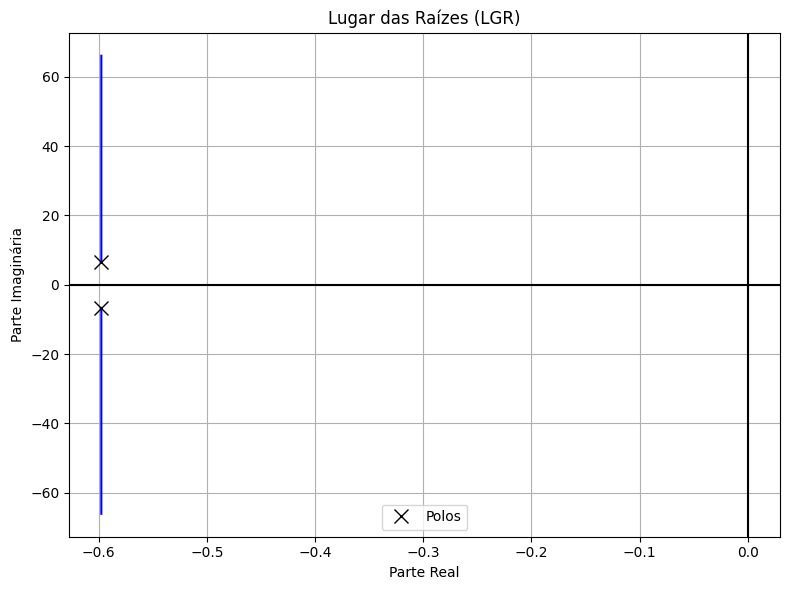

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import control

# Função de transferência
num = [4.326]
den = [1, 1.195, 45.207]
system = control.TransferFunction(num, den)

# vetor de ganhos mais amplo e denso
kvect = np.linspace(0, 1000, 2001)

# calcula raízes para cada K, sem plotar ainda
rlist, klist = control.root_locus(system, kvect=kvect, plot=False)

# plota cada ramo
plt.figure(figsize=(8,6))
for i in range(rlist.shape[1]):
    plt.plot(rlist[:,i].real, rlist[:,i].imag, 'b')

# polos e zeros iniciais
# Usar np.roots para calcular polos e zeros diretamente dos coeficientes
poles = np.roots(den)
if len(num) > 1:
    zeros = np.roots(num)
else:
    zeros = np.array([])
plt.plot(poles.real, poles.imag, 'xk', markersize=10, label='Polos')
if zeros.size:
    plt.plot(zeros.real, zeros.imag, 'ok', fillstyle='none', markersize=10, label='Zeros')

# eixos no zero
plt.axhline(0, color='black')
plt.axvline(0, color='black')

plt.grid(True)
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.title('Lugar das Raízes (LGR)')
plt.legend()
plt.tight_layout()
plt.show()